In [7]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

Satelli sampling means variance based sampling, but not a good measure for non-uniform distribution. Advantage: just extends series further if you want to increase number of samples
Parallelization of sampling --> batch run (concurrent)

# Added modules

In [ ]:
def get_theta(x, mu, sigma):
    """
    x: fraction of similar neighbours
    mu: optimal fraction of similar neighbours
    sigma: acceptance range
    """
    theta = np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))
    return theta

In [ ]:
def gaussian_function(x, mu, sigma):
    return np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))

# Example usage:
x_values = np.linspace(0, 1, 100)
mu = 0.5  # Peak in the middle
sigma = 0.6  # Controls the width

y_values = gaussian_function(x_values, mu, sigma)

# You can plot the function to visualize it
import matplotlib.pyplot as plt

plt.plot(x_values, y_values)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title(f'Gaussian Function with Peak at {mu}')
plt.show()

# Sobol Sensitivity Analysis

In [2]:
from SALib.sample import saltelli
from SALib.analyze import sobol

In [3]:
import modules as modules
import model as model
from model import Schelling

def schelling_SA(num_runs, num_steps, burn_in_period, minority_pc, property_value_weight, alpha, mu_theta, sigma_theta, density):

    # initialize storage for parameters
    overall_desirability_entropy = []
    overall_agent_entropy = []
    overall_utility = []

    # run the model several times for the same parameter setting 
    for _ in range(num_runs):

        # initialize model
        models = Schelling(
            property_value_func=modules.property_value_quadrants,
            income_func=modules.income_func,
            desirability_func=modules.desirability_func,
            utility_func=modules.utility_func,
            price_func=modules.price_func,
            compute_similar_neighbours=modules.compute_similar_neighbours,
            calculate_gi_star = modules.calculate_gi_star,
            update_interested_agents_func = modules.update_interested_agents_concurrently,
            height=20,
            width=20,
            radius=1,
            density=density,
            minority_pc=minority_pc,
            alpha=alpha,
            income_scale=1.5, # the scale by which the income is higher than the property value
            property_value_weight=property_value_weight,
            mu_theta = mu_theta,
            sigma_theta = sigma_theta,
            seed=42)

        # Run the model for a certain number of steps
        for _ in range(num_steps):
            models.step()

        # call necessary data collectors
        agent_data = models.datacollector.get_agent_vars_dataframe()
        model_data_entropy = models.datacollector.get_model_vars_dataframe()
    
        # Compute mean and standard deviation of entropies over time per run
        desirability_entropy = model_data_entropy['Desirability entropy'].to_numpy()
        # desirability_entropy_std = model_data_entropy['Desirability entropy'].std()
        mean_desirability_entropy = np.mean(desirability_entropy[burn_in_period::])
    
        agent_entropy = model_data_entropy['Agent entropy'].to_numpy()
        # agent_entropy_std = model_data_entropy['Agent entropy'].std()
        mean_agent_entropy = np.mean(agent_entropy[burn_in_period::])
    
        # Compute mean and standard deviation of utility per time step over each agent 
        utility_mean = agent_data.groupby(level='Step')['Utility'].mean()
        #utility_std = agent_data.groupby(level='Step')['Utility'].std()
    
        # Compute mean and standard deviation of utility over time 
        utility_mean = pd.DataFrame(utility_mean).to_numpy()
        #utility_std = pd.DataFrame(utility_std).to_numpy()
        mean_utility_interim = np.mean(utility_mean[burn_in_period::])

        # Append all results to storage
        overall_desirability_entropy.append(mean_desirability_entropy)
        overall_agent_entropy.append(mean_agent_entropy)
        overall_utility.append(mean_utility_interim)

    mean_desirability = np.mean(overall_desirability_entropy)
    mean_agent = np.mean(overall_agent_entropy)
    mean_utility = np.mean(overall_utility)

    return mean_desirability, mean_agent, mean_utility

In [4]:
a, b, c, d, e, f = [0.09375, 0.46875, 0.46875, 0.65625, 0.28125, 0.96875]
x = schelling_SA(2, 5, 2, a, b, c, d, e, f)

/Users/kayamarlenedisselkamp/Desktop/Master - Computational Science/Agent-Based Modelling/ABM-Notebooks-0-1/ABM_Group_3/Mesa Schelling Housing/modules.py:39: UserWarning: Default value 0 (int) might not be best suitable with dtype=float64.
  layer = mesa.space.PropertyLayer(name, width, height, 0)
/Users/kayamarlenedisselkamp/Desktop/Master - Computational Science/Agent-Based Modelling/ABM-Notebooks-0-1/ABM_Group_3/Mesa Schelling Housing/modules.py:39: FutureWarning: The new PropertyLayer and _PropertyGrid classes experimental. It may be changed or removed in any and all future releases, including patch releases.
We would love to hear what you think about this new feature. If you have any thoughts, share them with us here: https://github.com/projectmesa/mesa/discussions/1932
  layer = mesa.space.PropertyLayer(name, width, height, 0)
/Users/kayamarlenedisselkamp/Desktop/Master - Computational Science/Agent-Based Modelling/ABM-Notebooks-0-1/ABM_Group_3/Mesa Schelling Housing/model.py:149

In [5]:
# Step 1: Problem definition
problem = {
    'num_vars': 6,
    'names': ['density', 'minority_pc', 'property_value_weight', 'alpha', 'mu_theta', 'sigma_theta'],
    'bounds': [[0,1], [0,1], [0,1], [0,1], [0,1], [0,1]]
}

# Step 2: Generate samples 
samples = saltelli.sample(problem, 1) #2**5) #2024

/var/folders/v9/l1nzr55125v697bcr39l01hr0000gn/T/ipykernel_58763/732152587.py:9: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  samples = saltelli.sample(problem, 1) #2**5) #2024
/Users/kayamarlenedisselkamp/.local/share/virtualenvs/ABM-Notebooks-0-1-OzA5lFMJ/lib/python3.11/site-packages/SALib/sample/saltelli.py:109: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (1) is equal to `2^n`.
        
  warnings.warn(msg)


In [70]:
# Step 3: evaluate the model under the different parameter settings 
# Define settings 
iterations = 1
model_steps = 4
burn_in = 2

# Initialize storage for measures
result_desirability = np.zeros([samples.shape[0]])
result_agent = np.zeros([samples.shape[0]])
result_utility = np.zeros([samples.shape[0]])

for i, X in enumerate(samples):
    result_desirability[i] = schelling_SA(iterations, model_steps, burn_in, *X)[0]
    result_agent[i] = schelling_SA(iterations, model_steps, burn_in, *X)[1]
    result_utility[i] = schelling_SA(iterations, model_steps, burn_in, *X)[2]

In [22]:
# Step 4: analyse results
Si_desirability = sobol.analyze(problem, result_desirability, print_to_console=True)

                              ST       ST_conf
density                20.660260  6.998270e-15
minority_pc             0.780333  6.560878e-16
property_value_weight   0.098159  2.733699e-17
alpha                   1.316742  4.373919e-16
mu_theta                0.615343  0.000000e+00
sigma_theta             1.604562  1.312176e-15
                              S1       S1_conf
density               -12.762248  0.000000e+00
minority_pc             2.480271  0.000000e+00
property_value_weight   0.879679  0.000000e+00
alpha                  -3.221881  8.747838e-16
mu_theta               -2.202510  8.747838e-16
sigma_theta             3.556621  0.000000e+00
                                             S2       S2_conf
(density, minority_pc)                12.299219  0.000000e+00
(density, property_value_weight)      12.601563  6.998270e-15
(density, alpha)                      13.376327  1.749568e-14
(density, mu_theta)                   13.183773  1.049741e-14
(density, sigma_theta)          

In [18]:
Si_agent = sobol.analyze(problem, result_agent, print_to_console=True)

                             ST       ST_conf
density                0.747273  6.560878e-16
minority_pc            0.000003  1.668518e-21
property_value_weight  0.004988  0.000000e+00
alpha                  0.013181  3.417124e-18
mu_theta               0.000007  0.000000e+00
sigma_theta            1.503829  4.373919e-16
                             S1       S1_conf
density               -2.120150  8.747838e-16
minority_pc           -0.004391  3.417124e-18
property_value_weight  0.173224  1.093480e-16
alpha                  0.281580  0.000000e+00
mu_theta               0.006568  0.000000e+00
sigma_theta           -3.007643  8.747838e-16
                                            S2       S2_conf
(density, minority_pc)                2.953479  0.000000e+00
(density, property_value_weight)      2.635356  8.747838e-16
(density, alpha)                      2.441283  0.000000e+00
(density, mu_theta)                   2.933851  0.000000e+00
(density, sigma_theta)                8.332545  3.4

In [19]:
Si_utility = sobol.analyze(problem, result_utility, print_to_console=True)

                             ST       ST_conf
density                0.384650  2.186959e-16
minority_pc            0.740477  2.186959e-16
property_value_weight  0.105459  5.467399e-17
alpha                  5.519923  1.749568e-15
mu_theta               5.747145  3.499135e-15
sigma_theta            0.485640  0.000000e+00
                             S1       S1_conf
density                1.638484  4.373919e-16
minority_pc            2.273345  0.000000e+00
property_value_weight  0.857931  2.186959e-16
alpha                 -6.206917  3.499135e-15
mu_theta              -6.333379  1.749568e-15
sigma_theta            1.841054  4.373919e-16
                                             S2       S2_conf
(density, minority_pc)                -7.648599  1.749568e-15
(density, property_value_weight)      -3.451646  2.624351e-15
(density, alpha)                      17.496869  6.998270e-15
(density, mu_theta)                   17.871851  6.998270e-15
(density, sigma_theta)                -6.36677

In [45]:
# Step 5: Plots
# Set params generally for all plots
params = ['Density', 'Minority Percentage', 'Weight: property value', r"$\alpha$", r"$\mu$", r"$\sigma$"]

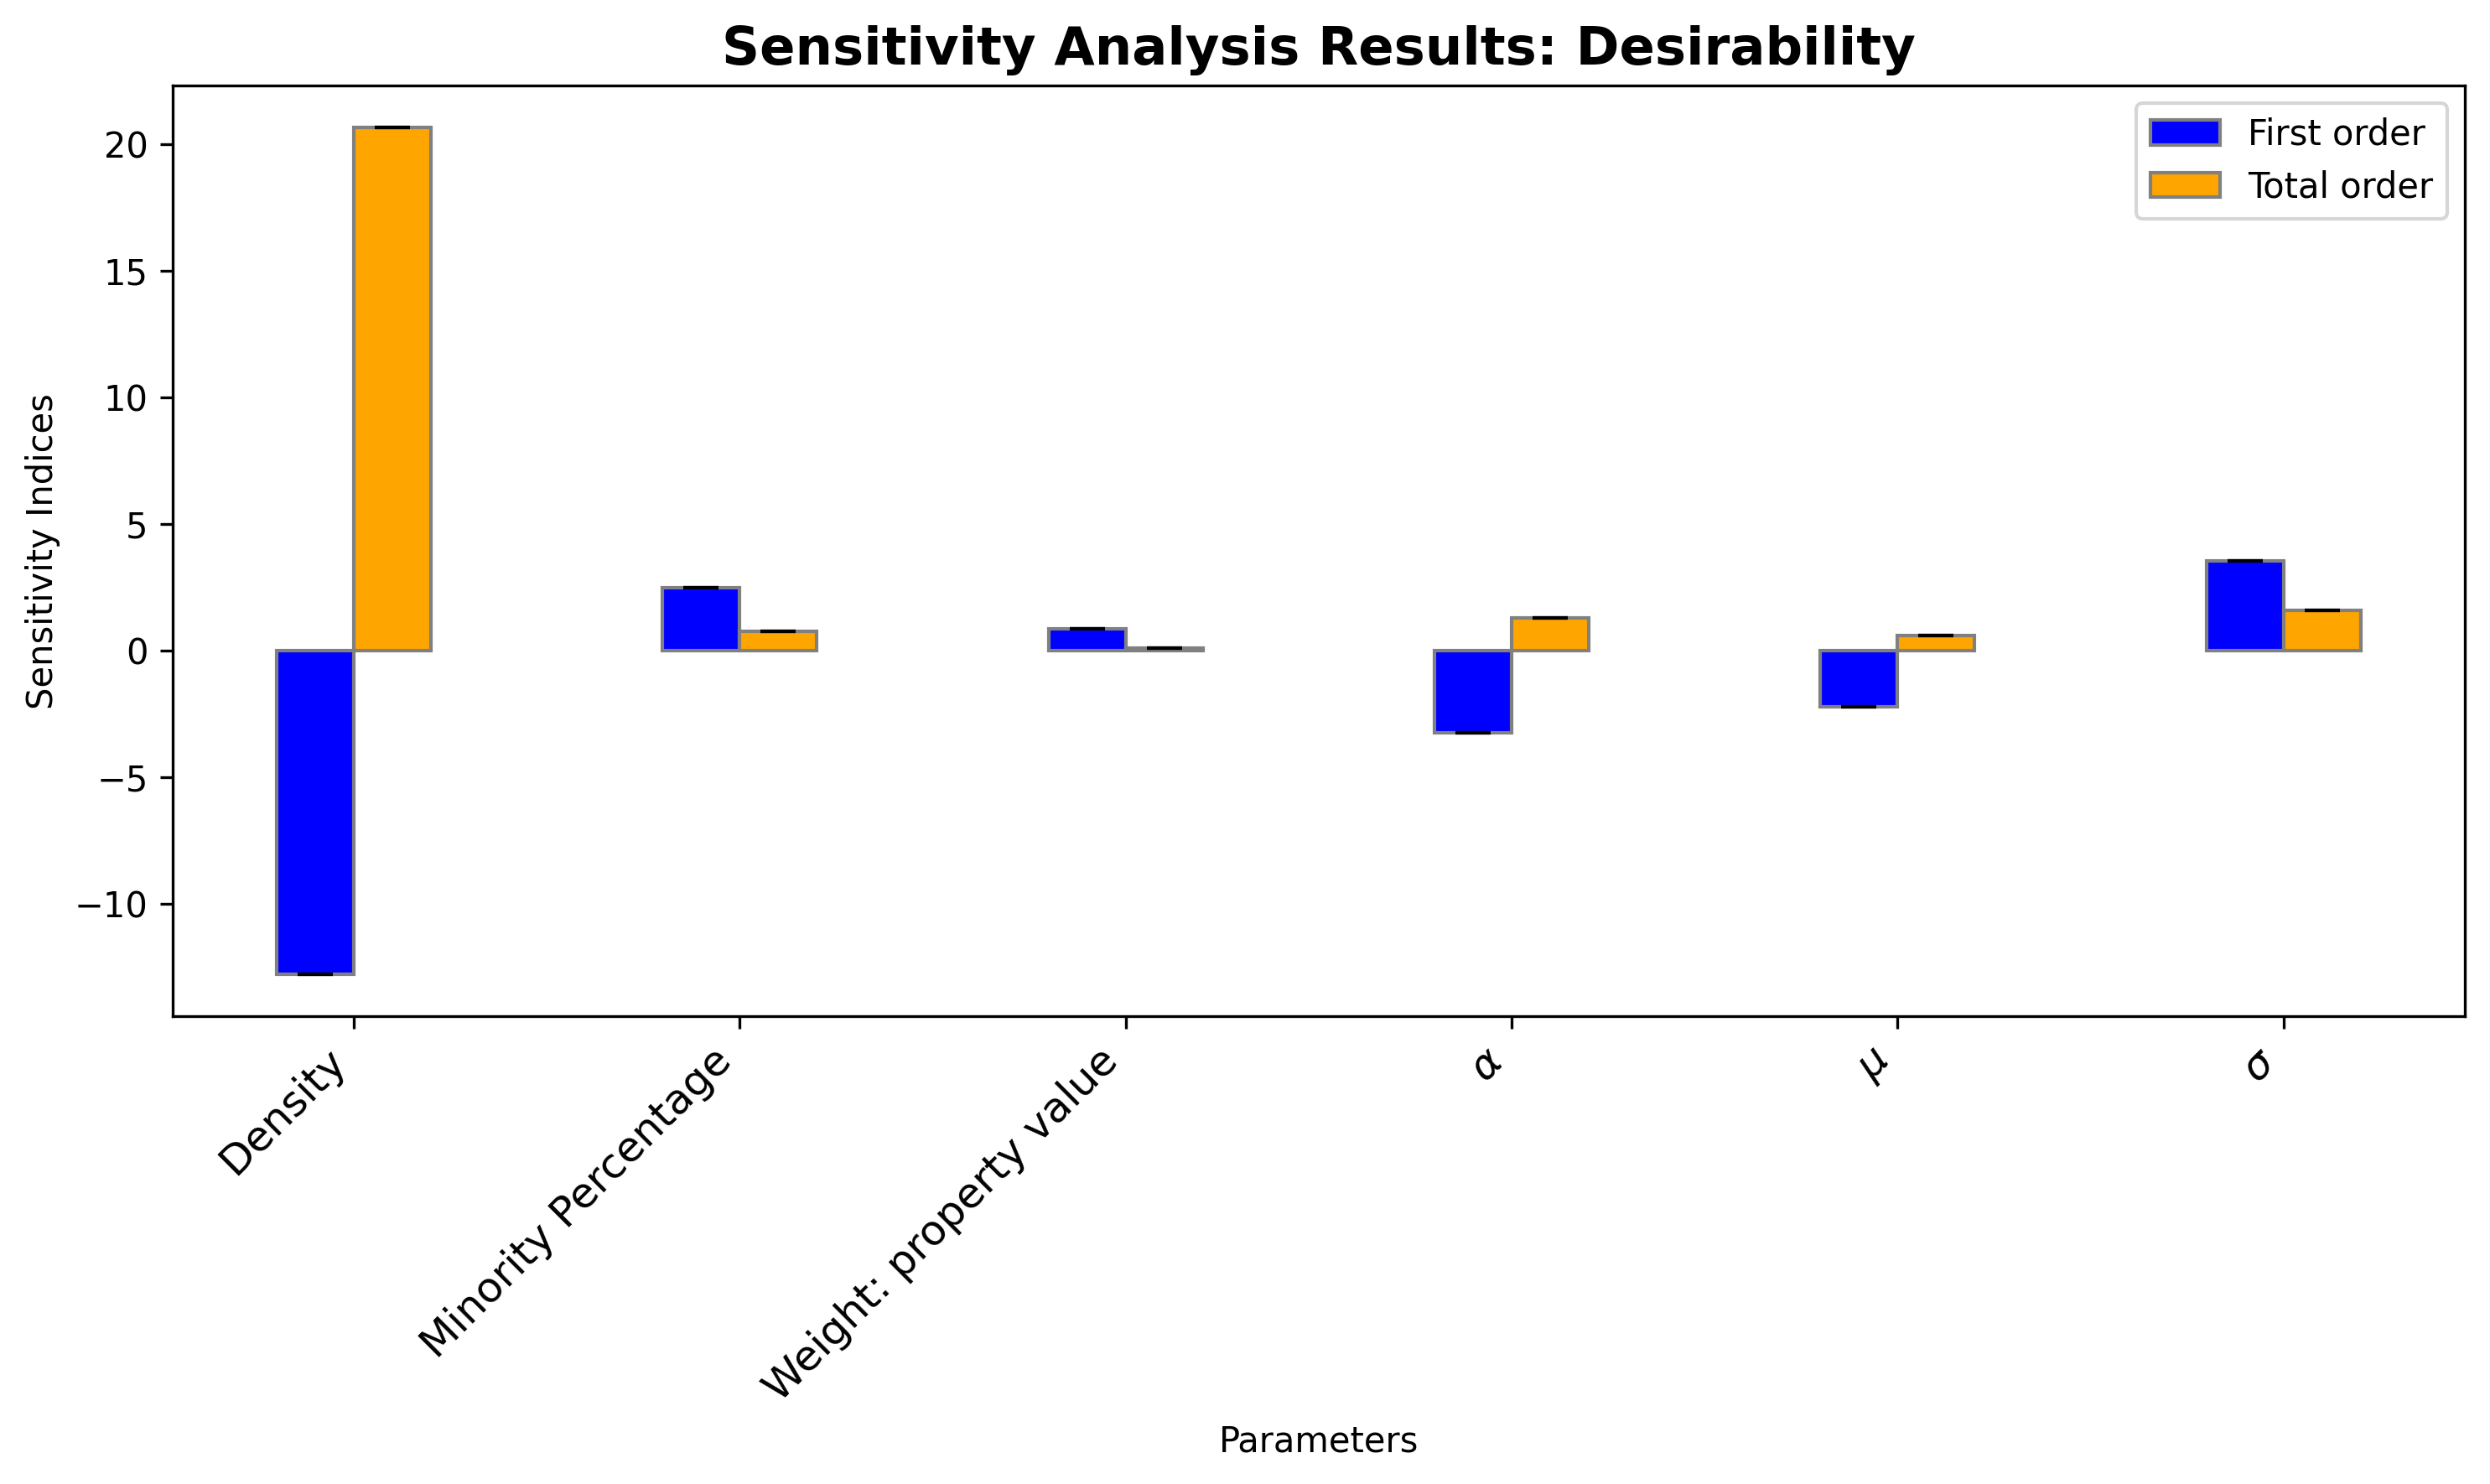

In [50]:
# Generate plot for desirability entropy
S1_desirability = Si_desirability['S1']
S1_conf_desirability = Si_desirability['S1_conf']

ST_desirability = Si_desirability['ST']
ST_conf_desirability = Si_desirability['ST_conf']

# Convert confidence intervals to errors (assuming symmetrical errors)
S1_err = np.array(S1_conf_desirability)
ST_err = np.array(ST_conf_desirability)

# Bar width
bar_width = 0.2

# Positions of the bars
r1 = np.arange(len(params))
r2 = [x + bar_width for x in r1]

# Create the figure and axis
fig, ax = plt.subplots(dpi = 300, figsize=(10, 6))

# Plot S1 and ST with error bars
bars1 = ax.bar(r1, S1_desirability, yerr=S1_err, capsize=5, color='blue', width=bar_width, edgecolor='grey', label='First order')
bars2 = ax.bar(r2, ST_desirability, yerr=ST_err, capsize=5, color='orange', width=bar_width, edgecolor='grey', label='Total order')

# Adding labels
ax.set_xlabel('Parameters', fontsize=10)
ax.set_ylabel('Sensitivity Indices', fontsize=10)
ax.set_title('Sensitivity Analysis Results: Desirability', fontweight='bold', fontsize=15)
ax.set_xticks([r + bar_width/2 for r in range(len(params))])
ax.set_xticklabels(params, rotation=45, ha='right', fontsize = 12)

# Add a legend
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()
plt.close()

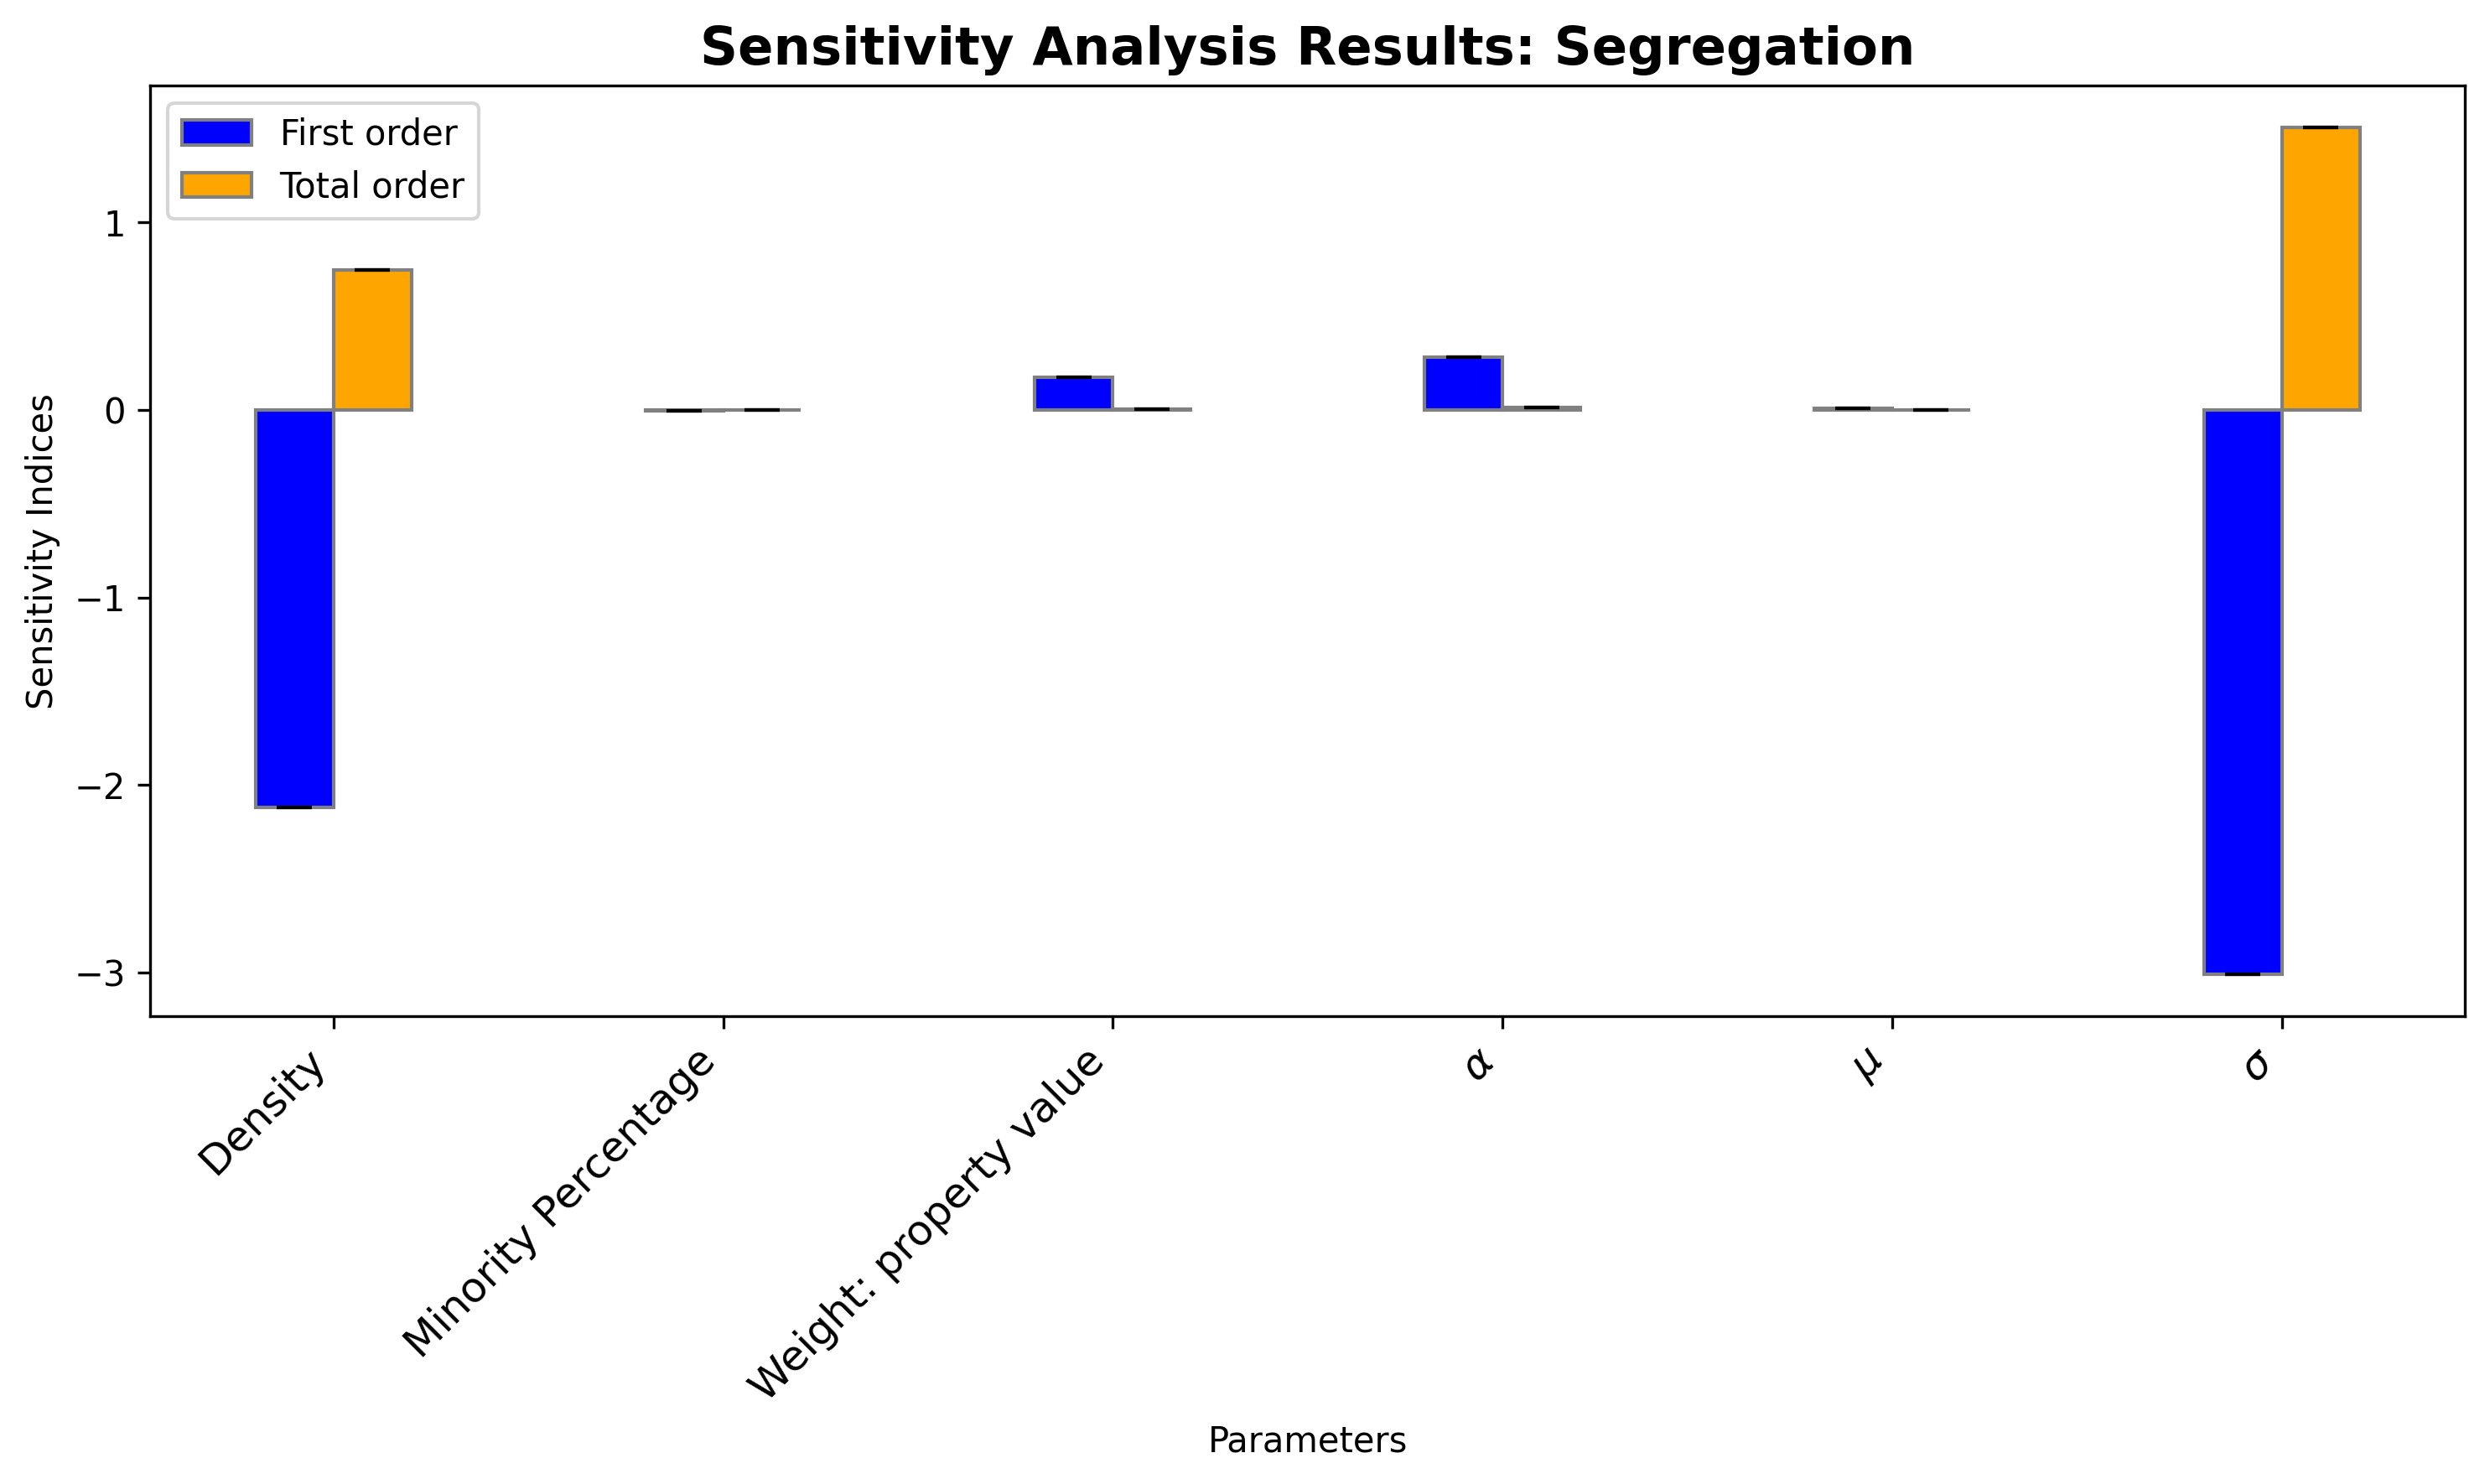

In [53]:
# Generate plot for desirability entropy
S1_agent = Si_agent['S1']
S1_conf_agent = Si_agent['S1_conf']

ST_agent = Si_agent['ST']
ST_conf_agent = Si_agent['ST_conf']

# Convert confidence intervals to errors (assuming symmetrical errors)
S1_err = np.array(S1_conf_agent)
ST_err = np.array(ST_conf_agent)

# Bar width
bar_width = 0.2

# Positions of the bars
r1 = np.arange(len(params))
r2 = [x + bar_width for x in r1]

# Create the figure and axis
fig, ax = plt.subplots(dpi = 300, figsize=(10, 6))

# Plot S1 and ST with error bars
bars1 = ax.bar(r1, S1_agent, yerr=S1_err, capsize=5, color='blue', width=bar_width, edgecolor='grey', label='First order')
bars2 = ax.bar(r2, ST_agent, yerr=ST_err, capsize=5, color='orange', width=bar_width, edgecolor='grey', label='Total order')

# Adding labels
ax.set_xlabel('Parameters', fontsize=10)
ax.set_ylabel('Sensitivity Indices', fontsize=10)
ax.set_title('Sensitivity Analysis Results: Segregation', fontweight='bold', fontsize=15)
ax.set_xticks([r + bar_width/2 for r in range(len(params))])
ax.set_xticklabels(params, rotation=45, ha='right', fontsize = 12)

# Add a legend
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()
plt.close()

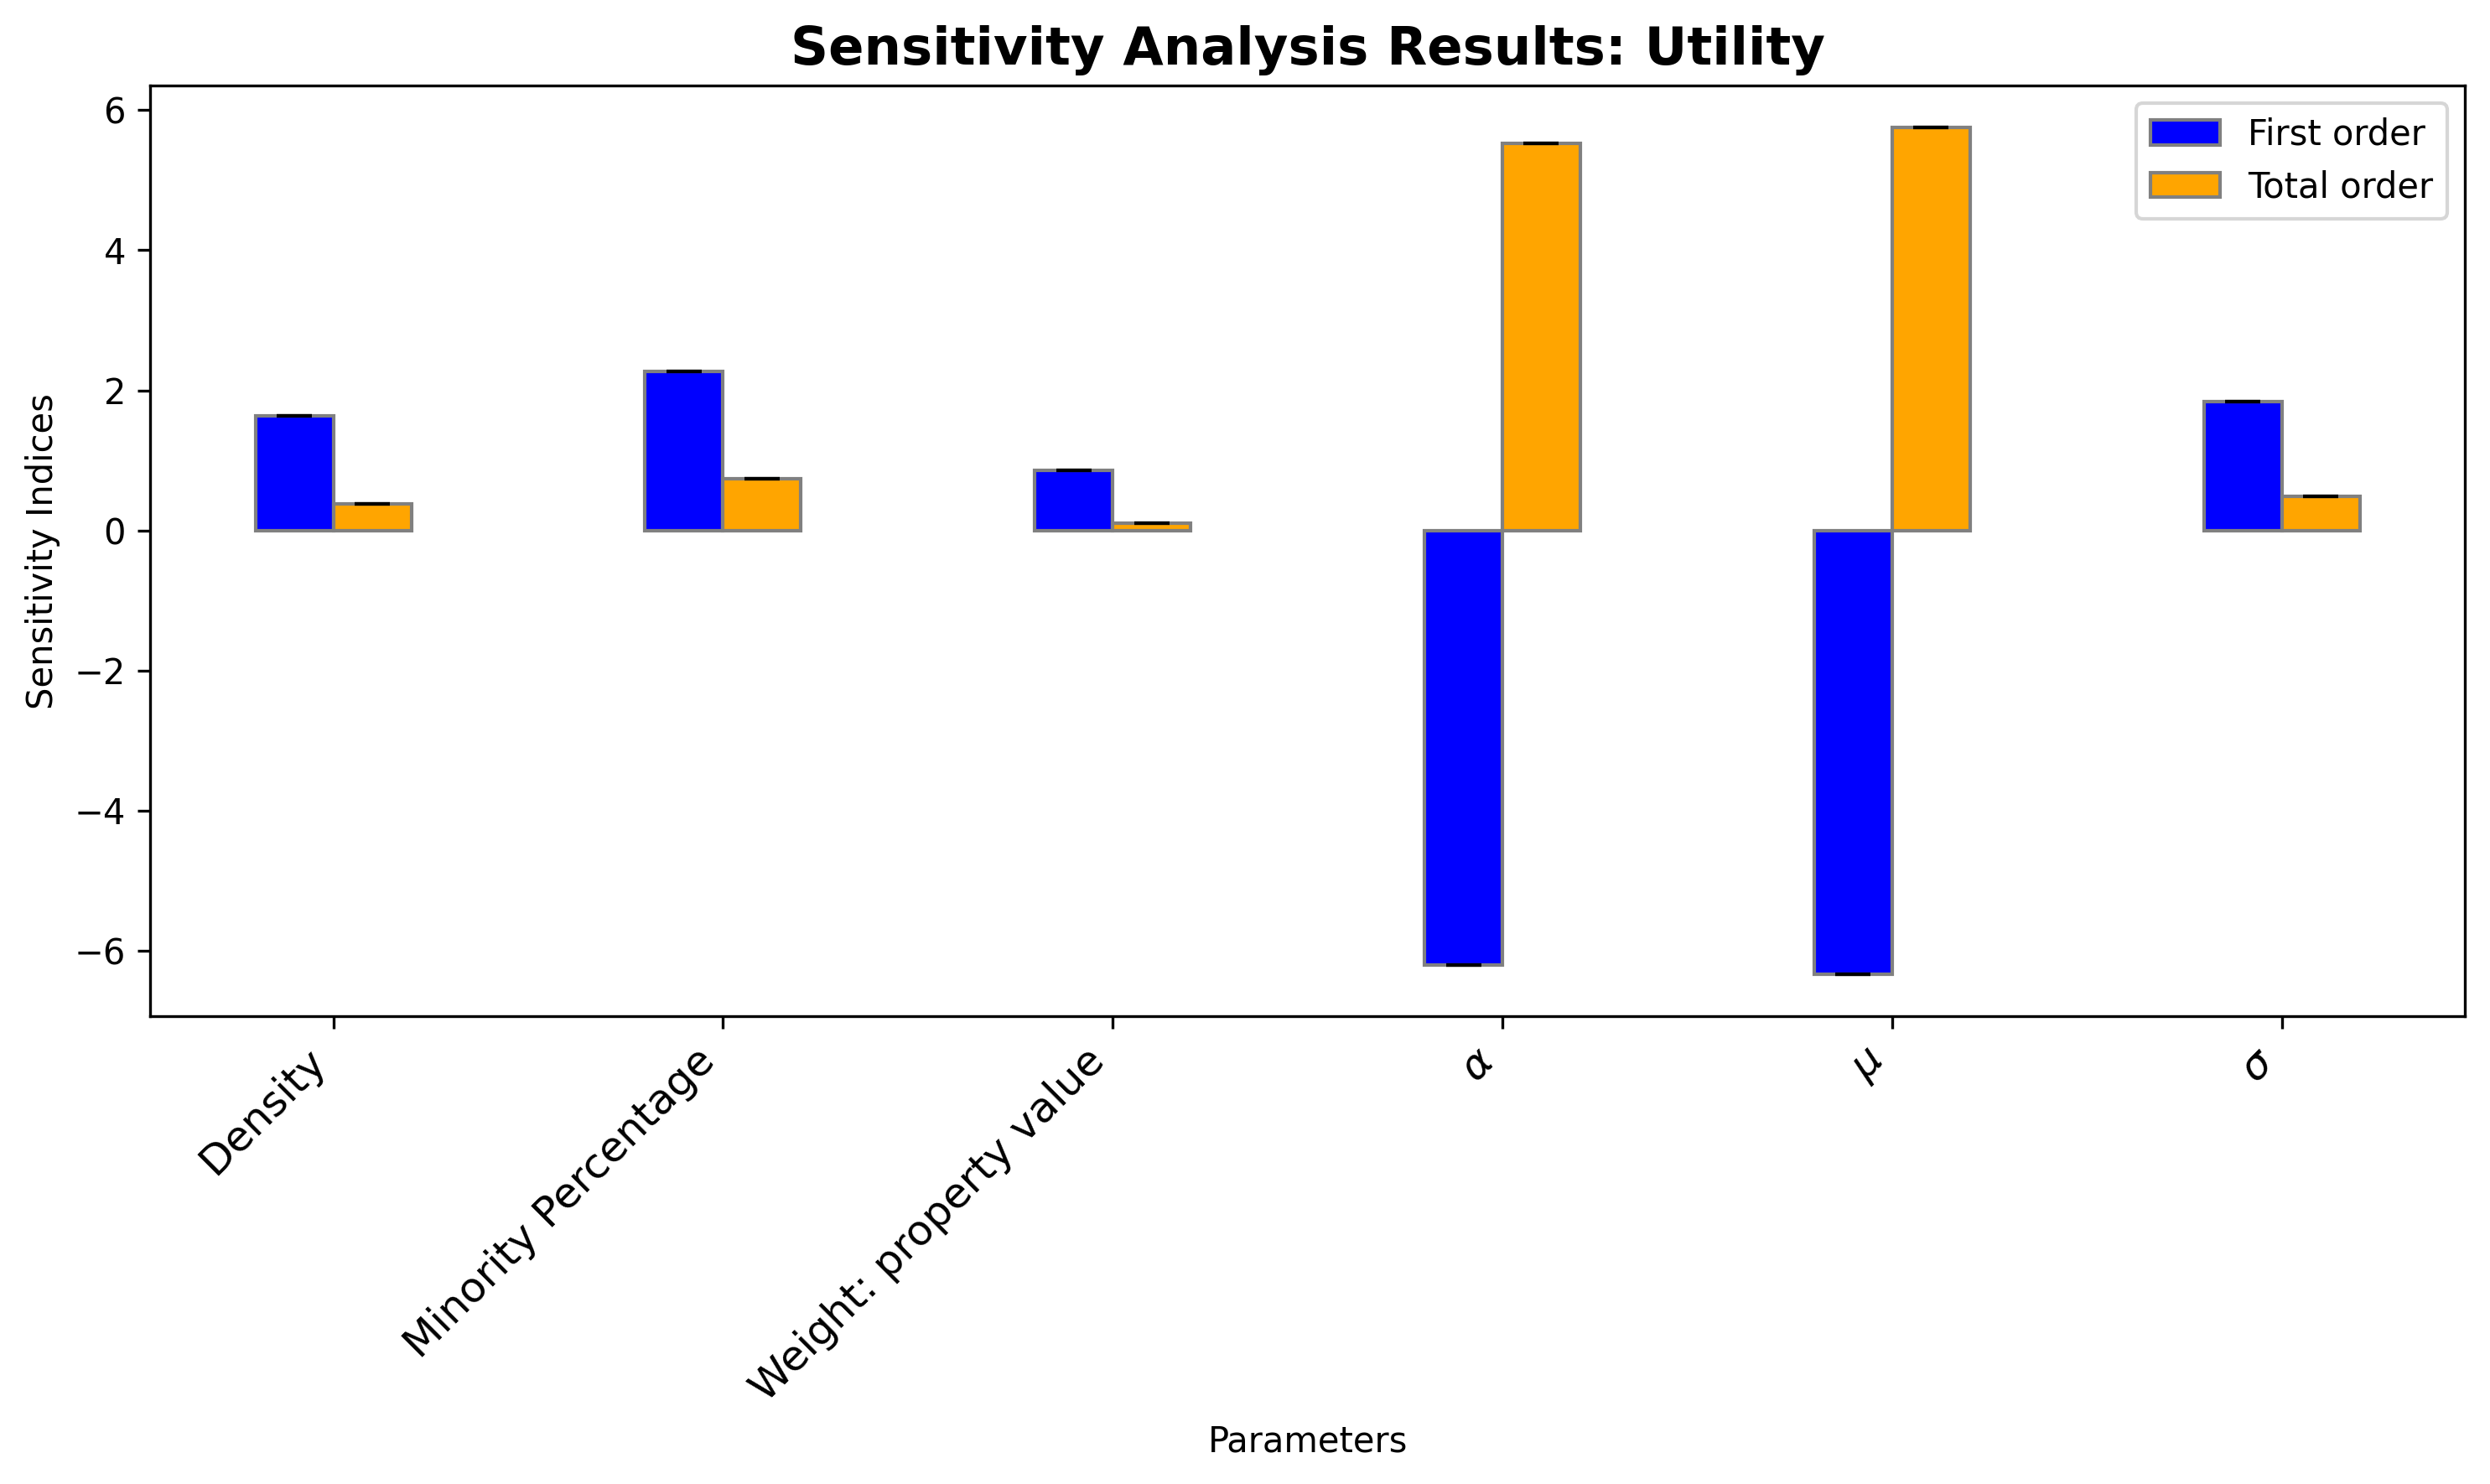

In [51]:
# Generate plot for desirability entropy
S1_utility = Si_utility['S1']
S1_conf_utility = Si_utility['S1_conf']

ST_utility = Si_utility['ST']
ST_conf_utility = Si_utility['ST_conf']

# Convert confidence intervals to errors (assuming symmetrical errors)
S1_err = np.array(S1_conf_utility)
ST_err = np.array(ST_conf_utility)

# Bar width
bar_width = 0.2

# Positions of the bars
r1 = np.arange(len(params))
r2 = [x + bar_width for x in r1]

# Create the figure and axis
fig, ax = plt.subplots(dpi = 300, figsize=(10, 6))

# Plot S1 and ST with error bars
bars1 = ax.bar(r1, S1_utility, yerr=S1_err, capsize=5, color='blue', width=bar_width, edgecolor='grey', label='First order')
bars2 = ax.bar(r2, ST_utility, yerr=ST_err, capsize=5, color='orange', width=bar_width, edgecolor='grey', label='Total order')

# Adding labels
ax.set_xlabel('Parameters', fontsize=10)
ax.set_ylabel('Sensitivity Indices', fontsize=10)
ax.set_title('Sensitivity Analysis Results: Utility', fontweight='bold', fontsize=15)
ax.set_xticks([r + bar_width/2 for r in range(len(params))])
ax.set_xticklabels(params, rotation=45, ha='right', fontsize = 12)

# Add a legend
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()
plt.close()

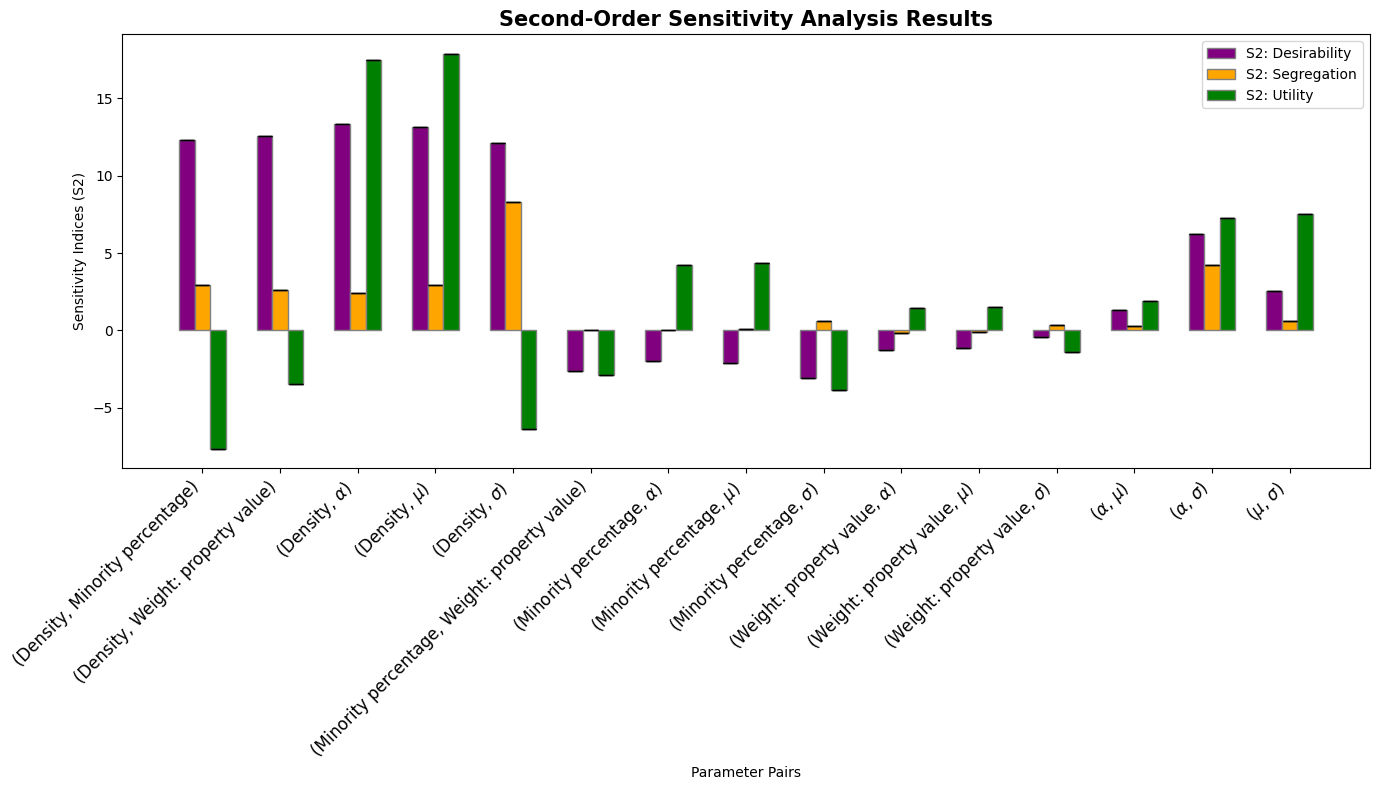

In [76]:
import matplotlib.pyplot as plt
import numpy as np

# Sensitivity analysis results
pairs = [
    '(Density, Minority percentage)', 
    '(Density, Weight: property value)', 
    r'(Density, $\alpha$)', 
    r'(Density, $\mu$)', 
    r'(Density, $\sigma$)', 
    '(Minority percentage, Weight: property value)', 
    r'(Minority percentage, $\alpha$)', 
    r'(Minority percentage, $\mu$)', 
    r'(Minority percentage, $\sigma$)', 
    r'(Weight: property value, $\alpha$)', 
    r'(Weight: property value, $\mu$)', 
    r'(Weight: property value, $\sigma$)', 
    r'($\alpha$, $\mu$)', 
    r'($\alpha$, $\sigma$)', 
    r'($\mu$, $\sigma$)'
]
# Three sets of S2 values and their confidence intervals
#S2_1 = [-7.648599, -3.451646, 17.496869, 17.871851, -6.366779, -2.890207, 4.236756, 4.364330, -3.881974, 1.459968, 1.505390, -1.430677, 1.926299, 7.244317, 7.497855]
#S2_1_conf = [1.749568e-15, 2.624351e-15, 6.998270e-15, 6.998270e-15, 3.499135e-15, 1.749568e-15, 3.499135e-15, 0.000000e+00, 8.747838e-16, 0.000000e+00, 1.312176e-15, 0.000000e+00, 0.000000e+00, 5.248703e-15, 0.000000e+00]
S2_desirability = np.array(Si_desirability['S2'])
S2_desirability = S2_desirability[~np.isnan(S2_desirability)]
S2_conf_desirability = np.array(Si_desirability['S2_conf'])
S2_conf_desirability = S2_conf_desirability[~np.isnan(S2_conf_desirability)]

#S2_2 = [2.953479, 2.635356, 2.441283, 2.933851, 8.332545, 0.053501, 0.035002, 0.081955, 0.596572, -0.145167, -0.102131, 0.369556, 0.305534, 4.200879, 0.636475]
#S2_2_conf = [0.000000e+00, 8.747838e-16, 0.000000e+00, 0.000000e+00, 3.499135e-15, 1.366850e-17, 0.000000e+00, 2.733699e-17, 0.000000e+00, 0.000000e+00, 5.467399e-17, 2.186959e-16, 0.000000e+00, 1.749568e-15, 2.186959e-16]
S2_agent = np.array(Si_agent['S2'])
S2_agent = S2_agent[~np.isnan(S2_agent)]
S2_conf_agent = np.array(Si_agent['S2_conf'])
S2_conf_agent = S2_conf_agent[~np.isnan(S2_conf_agent)]
#S2_3 = [12.299219, 12.601563, 13.376327, 13.183773, 12.095902, -2.618332, -1.952655, -2.118097, -3.052795, -1.266391, -1.145132, -0.460051, 1.319573, 6.229047, 2.523827]
#S2_3_conf = [0.000000e+00, 6.998270e-15, 1.749568e-14, 1.049741e-14, 1.049741e-14, 0.000000e+00, 4.373919e-16, 8.747838e-16, 2.624351e-15, 8.747838e-16, 8.747838e-16, 3.280439e-16, 0.000000e+00, 1.749568e-15, 8.747838e-16]
S2_utility = np.array(Si_utility['S2'])
S2_utility = S2_utility[~np.isnan(S2_utility)]
S2_conf_utility = np.array(Si_utility['S2_conf'])
S2_conf_utility = S2_conf_utility[~np.isnan(S2_conf_utility)]

# Convert confidence intervals to errors (assuming symmetrical errors)
S2_1_err = np.array(S2_conf_desirability)
S2_2_err = np.array(S2_conf_agent)
S2_3_err = np.array(S2_conf_utility)

# Ensure all arrays are of the same length
assert len(pairs) == len(S2_desirability) == len(S2_conf_desirability) == len(S2_agent) == len(S2_conf_agent) == len(S2_utility) == len(S2_conf_utility), "All input arrays must have the same length"

# Bar width
bar_width = 0.2

# Positions of the bars
positions = np.arange(len(pairs))
r1 = positions - bar_width
r2 = positions
r3 = positions + bar_width


# Create the figure and axis
fig, ax = plt.subplots(figsize=(14, 8))

# Plot S2_1, S2_2, S2_3 with error bars
bars1 = ax.bar(r1, S2_desirability, yerr=S2_1_err, capsize=5, color='purple', width=bar_width, edgecolor='grey', label='S2: Desirability')
bars2 = ax.bar(r2, S2_agent, yerr=S2_2_err, capsize=5, color='orange', width=bar_width, edgecolor='grey', label='S2: Segregation')
bars3 = ax.bar(r3, S2_utility, yerr=S2_3_err, capsize=5, color='green', width=bar_width, edgecolor='grey', label='S2: Utility')

# Adding labels
ax.set_xlabel('Parameter Pairs', fontsize=10)
ax.set_ylabel('Sensitivity Indices (S2)', fontsize=10)
ax.set_title('Second-Order Sensitivity Analysis Results', fontweight='bold', fontsize=15)
ax.set_xticks(positions)
ax.set_xticklabels(pairs, rotation=45, ha='right', fontsize=12)

# Add a legend
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

15 15
15 15
15 15


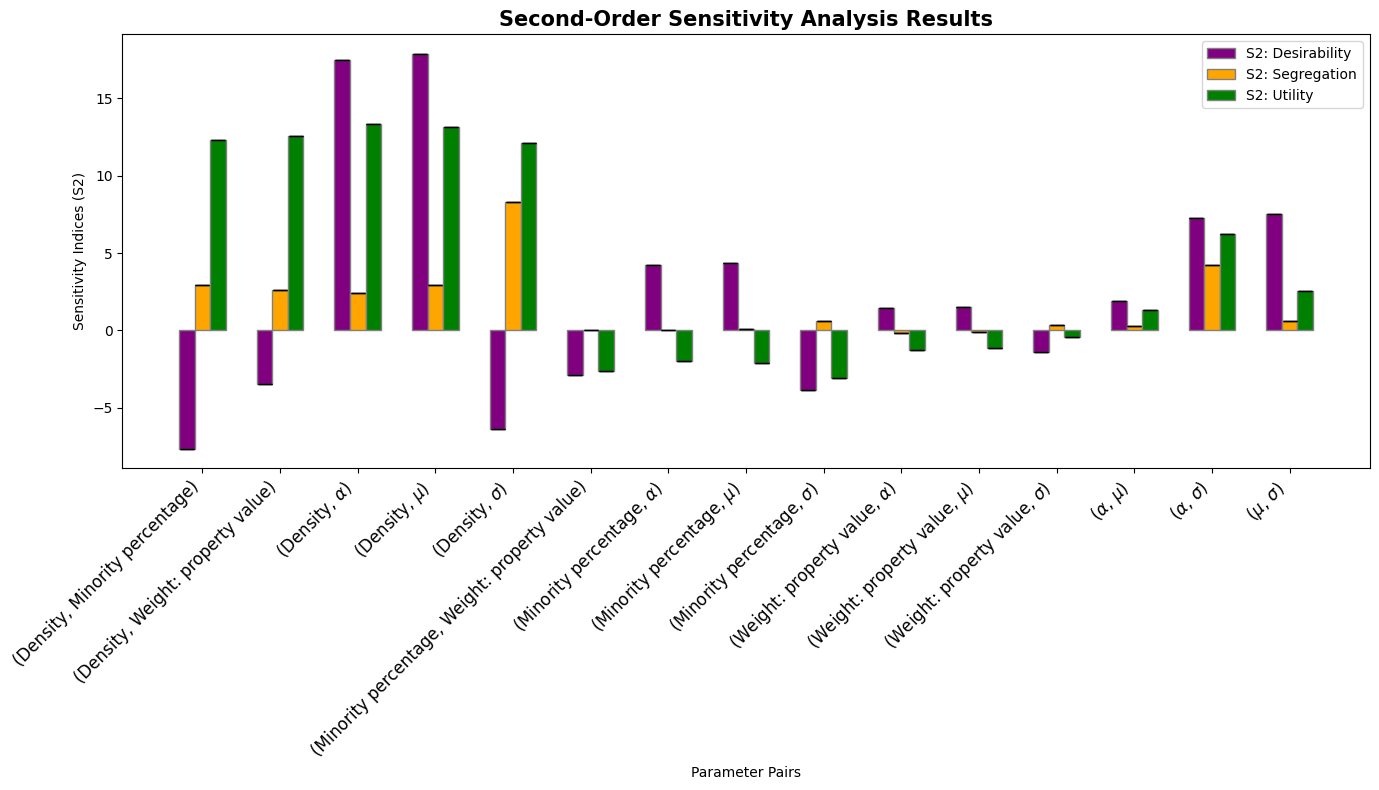

In [67]:
import matplotlib.pyplot as plt
import numpy as np

# Sensitivity analysis results
pairs = [
    '(Density, Minority percentage)', 
    '(Density, Weight: property value)', 
    r'(Density, $\alpha$)', 
    r'(Density, $\mu$)', 
    r'(Density, $\sigma$)', 
    '(Minority percentage, Weight: property value)', 
    r'(Minority percentage, $\alpha$)', 
    r'(Minority percentage, $\mu$)', 
    r'(Minority percentage, $\sigma$)', 
    r'(Weight: property value, $\alpha$)', 
    r'(Weight: property value, $\mu$)', 
    r'(Weight: property value, $\sigma$)', 
    r'($\alpha$, $\mu$)', 
    r'($\alpha$, $\sigma$)', 
    r'($\mu$, $\sigma$)'
]

# Example data (replace with your actual data)
S2_desirability = [-7.648599, -3.451646, 17.496869, 17.871851, -6.366779, -2.890207, 4.236756, 4.364330, -3.881974, 1.459968, 1.505390, -1.430677, 1.926299, 7.244317, 7.497855]
S2_conf_desirability = [1.749568e-15, 2.624351e-15, 6.998270e-15, 6.998270e-15, 3.499135e-15, 1.749568e-15, 3.499135e-15, 0.000000e+00, 8.747838e-16, 0.000000e+00, 1.312176e-15, 0.000000e+00, 0.000000e+00, 5.248703e-15, 0.000000e+00]
print(len(S2_desirability), len(S2_conf_desirability))
S2_agent = [2.953479, 2.635356, 2.441283, 2.933851, 8.332545, 0.053501, 0.035002, 0.081955, 0.596572, -0.145167, -0.102131, 0.369556, 0.305534, 4.200879, 0.636475]
S2_conf_agent = [0.000000e+00, 8.747838e-16, 0.000000e+00, 0.000000e+00, 3.499135e-15, 1.366850e-17, 0.000000e+00, 2.733699e-17, 0.000000e+00, 0.000000e+00, 5.467399e-17, 2.186959e-16, 0.000000e+00, 1.749568e-15, 2.186959e-16]
print(len(S2_agent), len(S2_conf_agent))
S2_utility = [12.299219, 12.601563, 13.376327, 13.183773, 12.095902, -2.618332, -1.952655, -2.118097, -3.052795, -1.266391, -1.145132, -0.460051, 1.319573, 6.229047, 2.523827]
S2_conf_utility = [0.000000e+00, 6.998270e-15, 1.749568e-14, 1.049741e-14, 1.049741e-14, 0.000000e+00, 4.373919e-16, 8.747838e-16, 2.624351e-15, 8.747838e-16, 8.747838e-16, 3.280439e-16, 0.000000e+00, 1.749568e-15, 8.747838e-16]
print(len(S2_utility), len(S2_conf_utility))
# Ensure all arrays are of the same length
assert len(pairs) == len(S2_desirability) == len(S2_conf_desirability) == len(S2_agent) == len(S2_conf_agent) == len(S2_utility) == len(S2_conf_utility), "All input arrays must have the same length"

# Bar width
bar_width = 0.2

# Positions of the bars
positions = np.arange(len(pairs))
r1 = positions - bar_width
r2 = positions
r3 = positions + bar_width

# Create the figure and axis
fig, ax = plt.subplots(figsize=(14, 8))

# Plot S2_1, S2_2, S2_3 with error bars
bars1 = ax.bar(r1, S2_desirability, yerr=S2_conf_desirability, capsize=5, color='purple', width=bar_width, edgecolor='grey', label='S2: Desirability')
bars2 = ax.bar(r2, S2_agent, yerr=S2_conf_agent, capsize=5, color='orange', width=bar_width, edgecolor='grey', label='S2: Segregation')
bars3 = ax.bar(r3, S2_utility, yerr=S2_conf_utility, capsize=5, color='green', width=bar_width, edgecolor='grey', label='S2: Utility')

# Adding labels
ax.set_xlabel('Parameter Pairs', fontsize=10)
ax.set_ylabel('Sensitivity Indices (S2)', fontsize=10)
ax.set_title('Second-Order Sensitivity Analysis Results', fontweight='bold', fontsize=15)
ax.set_xticks(positions)
ax.set_xticklabels(pairs, rotation=45, ha='right', fontsize=12)

# Add a legend
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()
